In [17]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

folder = '../../data/training/dev/data'
plot_folder = 'plots/dev'

make_dir(plot_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
metrics_df = pd.read_parquet(os.path.join(folder, 'metrics.parquet'))
confusion_matrix_df = pd.read_parquet(os.path.join(folder, 'confusion_matrix.parquet'))
synthethetic_df = pd.read_parquet(os.path.join(folder, 'synthetic_predicitions.parquet'))

metrics_df['shuffle_feature'] = metrics_df['shuffle_feature'].fillna('none')

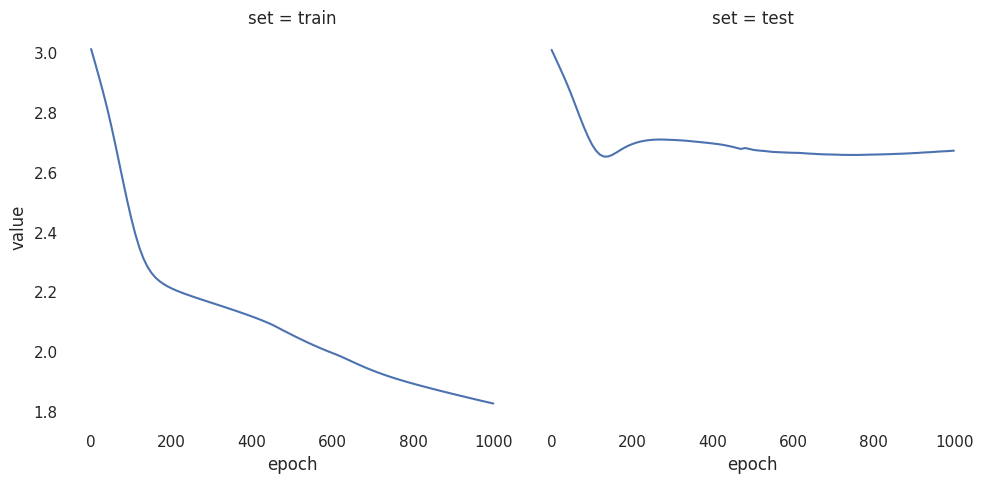

In [19]:
metric_name = 'log_loss'

# selection = best_labels[metric_name].copy()

selection = {
    'name': 'log_loss',
    'shuffle_feature': 'none'
}

focus = []

for f in focus:
    if f in selection:
        selection.pop(f)


w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.relplot(
    data=metrics_df[w1 & w2].copy(), 
    x='epoch', y='value',
    hue=focus[0] if len(focus) >= 1 else None, 
    style=focus[1] if len(focus) >= 2 else None,  
    col='set', row=focus[2] if len(focus) >= 3 else None, 
    kind='line', ci=None)

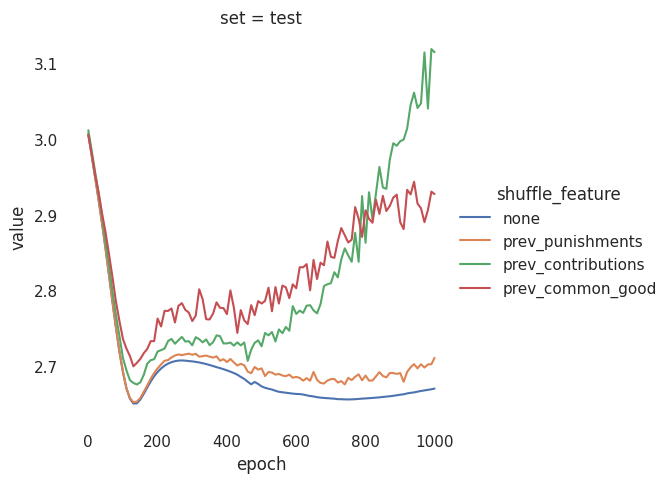

In [20]:
metric_name = 'log_loss'

# selection = best_labels[metric_name].copy()

selection = {
    'name': 'log_loss',
    'set': 'test'
}

focus = ['shuffle_feature']

for f in focus:
    if f in selection:
        selection.pop(f)

df = metrics_df[metrics_df['shuffle_feature'] == 'none']


w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.relplot(
    data=metrics_df[w1 & w2].copy(), 
    x='epoch', y='value',
    hue=focus[0] if len(focus) >= 1 else None, 
    style=focus[1] if len(focus) >= 2 else None,  
    col='set', row=focus[2] if len(focus) >= 3 else None, 
    kind='line', ci=None)

In [21]:
def _plot_heatmap(data, x, y, values, normalise=True):
    dfg = data.groupby([x,y])[values].sum()
    dfg = dfg.reset_index()
    if normalise:
        dfg[values] = dfg[values] / dfg.groupby([x])[values].transform('sum')
    cm = dfg.pivot_table(index=x, columns=y, values=values)
    cm = cm.sort_index(ascending=False)
    sns.heatmap(cm)

# def _plot_heatmap(data, x, y, values, normalise=True):
#     dfg = data.groupby([x,y])[values].sum()
#     dfg = dfg.reset_index()
#     if normalise:
#         dfg[values] = dfg[values] / dfg.groupby([x])[values].transform('sum')
#     cm = dfg.pivot_table(index=x, columns=y, values=values)
#     cm = cm.sort_index(ascending=False)
#     sns.heatmap(cm)


In [22]:
confusion_matrix_df.head()

,set,cv_split,epoch,idx,round_number,pred_contribution,proba,valid,true_contribution
0,test,0,999,0,0,0,0.004202,True,15
1,test,0,999,0,0,1,0.031395,True,15
2,test,0,999,0,0,2,0.001168,True,15
3,test,0,999,0,0,3,0.036154,True,15
4,test,0,999,0,0,4,0.002881,True,15


In [40]:
df = confusion_matrix_df.copy()
df = df[df['valid']]

# df = df.groupby(['round_number','pred_contribution', 'true_contribution'])['proba'].mean()
x='true_contribution'
y='pred_contribution'
values='proba'
normalise=True


dfg = df.groupby([x,y])[values].sum()
dfg = dfg.reset_index()
if normalise:
    dfg[values] = dfg[values] / dfg.groupby([x])[values].transform('sum')
cm = dfg.pivot_table(index=x, columns=y, values=values)

In [38]:
cm.loc[[19,20]]

pred_contribution,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
true_contribution,,,,,,,,,,,,,,,,,,,,,
19,0.008327,0.002808,0.002644,0.004605,0.007617,0.029241,0.008869,0.009701,0.013497,0.015965,...,0.013424,0.026721,0.062793,0.048539,0.069238,0.023875,0.037563,0.035306,0.021045,0.535808
20,0.008699,0.003624,0.002700,0.006013,0.009287,0.026772,0.010261,0.011304,0.017327,0.012634,...,0.015046,0.031173,0.045164,0.036084,0.056739,0.032262,0.061984,0.055709,0.033427,0.496495


<AxesSubplot:xlabel='true_contribution', ylabel='proba'>

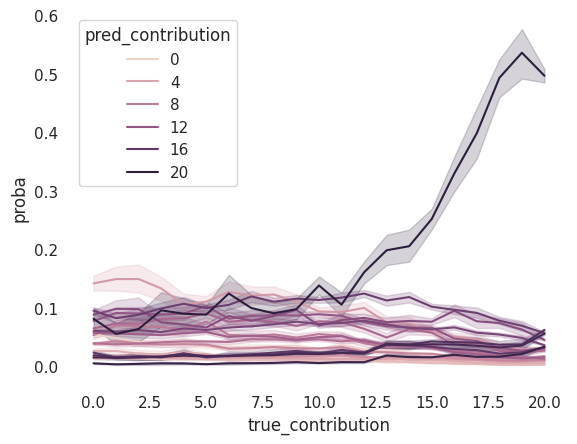

In [42]:
df = df.reset_index()

sns.lineplot(data=df, y='proba', x='true_contribution', hue='pred_contribution')

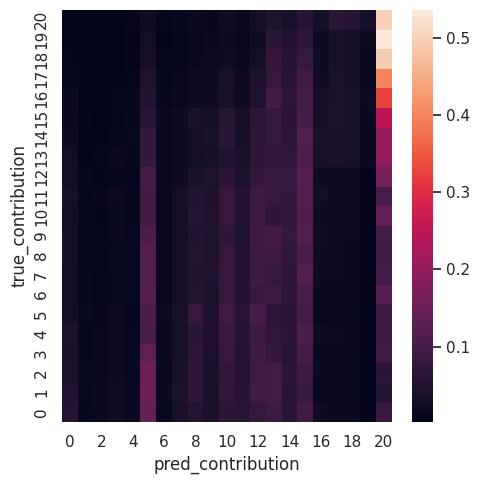

In [30]:
df = confusion_matrix_df.copy()

df['round_number_bin'] = df['round_number'] // 4

w = (
    # (df['shuffle_feature'] == 'None') &
    (df['valid'])
    # (df['set'] == 'test')
)

df = df[w]

focus_dimensions = []


plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='true_contribution',y='pred_contribution', values='proba', normalise=True)

fg = sns.FacetGrid(
    df, col=focus_dimensions[0] if len(focus_dimensions) > 0 else None,
    row=focus_dimensions[1] if len(focus_dimensions) > 1 else None,
    height=5)
fg.map_dataframe(plot_heatmap)

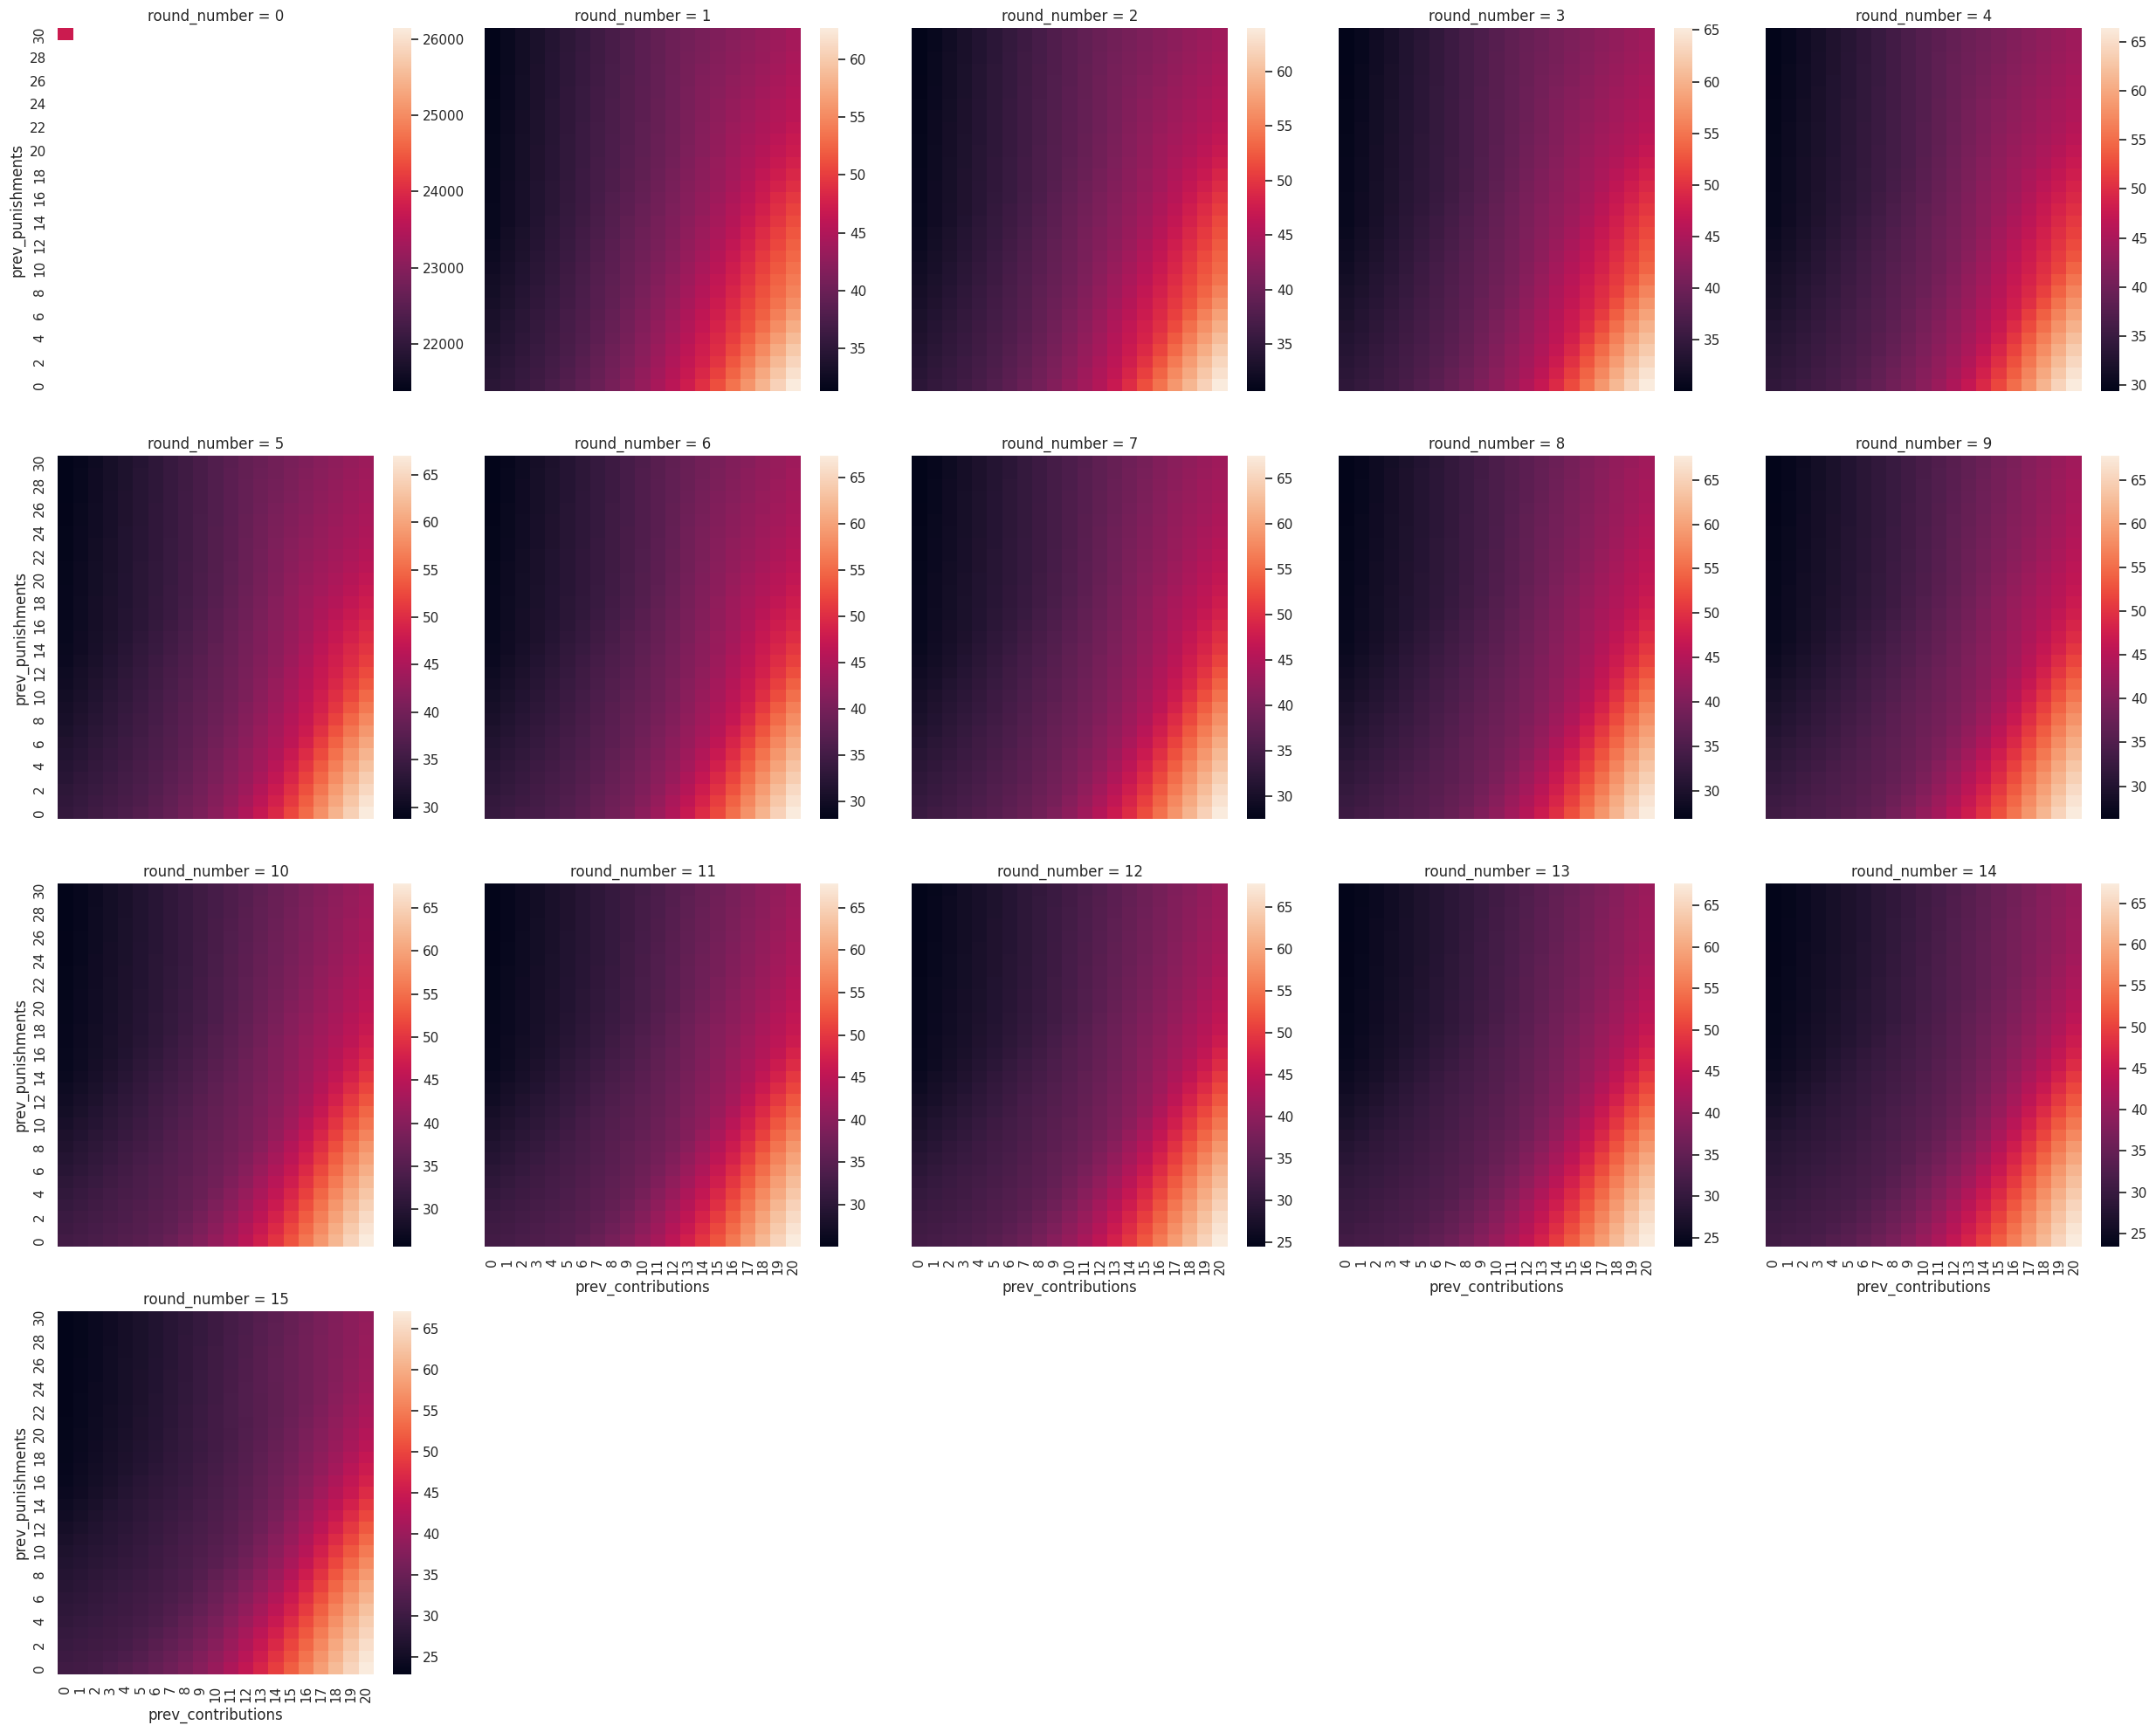

In [25]:
df = synthethetic_df.groupby(['idx','round_number']).agg({'prev_contributions': 'first', 'prev_punishments': 'first', 'round_number': 'first', 'exp_contribution': 'mean'}).reset_index(drop=True)

# w = (
#     (df['shuffle_feature'] == 'None')
# )

# df = df[w]

focus_dimensions = ['round_number']


plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='prev_punishments',y='prev_contributions', values='exp_contribution', normalise=False)

fg = sns.FacetGrid(
    df, col=focus_dimensions[0] if len(focus_dimensions) > 0 else None,
    row=focus_dimensions[1] if len(focus_dimensions) > 1 else None,
    col_wrap=5 if len(focus_dimensions) < 2 else None,
    height=5)
fg.map_dataframe(plot_heatmap)